# Paper vs Reality: Options Strategies Compared to Academic Claims

We run **10 options overlay strategies** on SPY (2008–2025) and compare our empirical results to predictions from academic finance.

## The Volatility Risk Premium (VRP)

The central concept underlying most options strategies is the **Variance Risk Premium**:

$$\text{VRP} = \sigma^2_{\text{implied}} - \sigma^2_{\text{realized}}$$

Carr & Wu (2009) show this is consistently **positive** — implied volatility exceeds realized volatility on average. This means:
- **Option sellers** systematically collect a premium (like insurance companies)
- **Option buyers** systematically overpay (like insurance policyholders)

## Strategies Tested

| # | Strategy | Direction | Paper | Claim |
|---|----------|-----------|-------|-------|
| 1 | **Covered Call** (BXM) | Sell vol | Whaley 2002 | Comparable returns, $\frac{2}{3}$ volatility |
| 2 | **Cash-Secured Puts** (PUT) | Sell vol | Neuberger Berman | Beats BXM by ~1%/yr |
| 3 | **OTM Put Hedge** | Buy vol | Israelov 2017 | Pure drag — erodes $\frac{2}{3}$ of equity returns |
| 4 | **OTM Call Momentum** | Buy vol | Kang 2016 | OTM call activity predicts $+18$bps/week |
| 5 | **Short Strangle** | Sell vol | Berman 2014 | 15.2% CAGR vs 9.9% S&P 500 |
| 6 | **Long Straddle** | Buy vol | Carr & Wu 2009 | $\text{VRP} > 0 \Rightarrow$ buying vol loses |
| 7 | **Collar** | Mixed | Israelov 2015 | Hidden costs, reduces equity risk premium |
| 8 | **Deep OTM Tail Hedge** | Buy vol | Spitznagel vs AQR | Debated: 12.3% CAGR vs persistent drag |
| 9 | **VIX-Timed Puts** | Conditional | Fassas 2019 | VIX term structure as contrarian signal |
| 10 | **SMA-Timed** | Conditional | Antonacci 2013 | Trend-following overlay adds value |

In [1]:
import os, sys, warnings, math
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'notebooks'))
os.chdir(PROJECT_ROOT)

from backtester import Direction
from backtest_runner import (
    load_data, run_backtest, INITIAL_CAPITAL,
    make_puts_strategy, make_calls_strategy,
    make_straddle_strategy, make_strangle_strategy,
    make_covered_call_strategy, make_cash_secured_put_strategy,
    make_collar_strategy, make_deep_otm_put_strategy,
)
from nb_style import apply_style, shade_crashes, color_excess, style_returns_table, CRASH_PERIODS, FT_BG, FT_BLUE, FT_RED, FT_GREEN, FT_DARK, FT_GREY

apply_style()
%matplotlib inline

# Crash periods for local use
CRASHES = [(label, start, end) for label, start, end, _ in CRASH_PERIODS]

print('Setup done.')

Setup done.


In [2]:
data = load_data()
schema = data['schema']
spy_prices = data['spy_prices']
years = data['years']

Loading data...


Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00 (17.9 years)
SPY B&H: 555.5% total, 11.05% annual, -51.9% max DD

Loaded macro signals: ['gdp', 'vix', 'hy_spread', 'yield_curve_10y2y', 'nfc_equity_mv', 'nfc_net_worth', 'dollar_index', 'buffett_indicator', 'tobin_q']


---
## Run All 10 Strategies

All use 99%/1% stock/options split unless otherwise noted.

In [3]:
S, O = 0.99, 0.01  # standard split

configs = [
    # (name, stock_pct, opt_pct, strategy_fn, budget_fn)
    ('1. Covered Call (BXM)',      S, O, lambda: make_covered_call_strategy(schema), None),
    ('2. Cash-Secured Puts (PUT)', S, O, lambda: make_cash_secured_put_strategy(schema), None),
    ('3. OTM Put Hedge',           S, O, lambda: make_puts_strategy(schema), None),
    ('4. OTM Call Momentum',       S, O, lambda: make_calls_strategy(schema), None),
    ('5. Short Strangle',          S, O, lambda: make_strangle_strategy(schema, Direction.SELL), None),
    ('6. Long Straddle',           S, O, lambda: make_straddle_strategy(schema, Direction.BUY), None),
    ('7. Collar',                  S, O, lambda: make_collar_strategy(schema), None),
    ('8. Deep OTM Tail Hedge',     0.997, 0.003, lambda: make_deep_otm_put_strategy(schema), None),
]

results = []
for name, s_pct, o_pct, strat_fn, bfn in configs:
    print(f'{name}...', end=' ', flush=True)
    r = run_backtest(name, s_pct, o_pct, strat_fn, data, budget_fn=bfn)
    results.append(r)
    print(f'annual {r["annual_ret"]:+.2f}%, excess {r["excess_annual"]:+.2f}%, DD {r["max_dd"]:.1f}%')

print('\nDone.')

1. Covered Call (BXM)... 

annual +66.09%, excess +55.04%, DD -43.7%
2. Cash-Secured Puts (PUT)... 

annual +43.19%, excess +32.14%, DD -85.2%
3. OTM Put Hedge... 

annual +7.62%, excess -3.42%, DD -49.3%
4. OTM Call Momentum... 

annual +11.88%, excess +0.83%, DD -55.2%
5. Short Strangle... 

annual +47.18%, excess +36.14%, DD -340.5%
6. Long Straddle... 

annual +10.67%, excess -0.37%, DD -51.1%
7. Collar... 

annual +nan%, excess +nan%, DD -386.0%
8. Deep OTM Tail Hedge... 

annual +8.69%, excess -2.36%, DD -51.9%

Done.


In [4]:
# VIX-timed puts: buy puts only when VIX > rolling 1yr median
if data['vix'] is not None:
    vix, vix_med = data['vix'], data['vix_median']
    def vix_high_budget(date, tc):
        cur = vix.asof(date)
        thresh = vix_med.asof(date) if vix_med is not None else None
        if pd.isna(cur) or thresh is None or pd.isna(thresh):
            return 0
        return tc * 0.01 if cur > thresh else 0

    print('9. VIX-Timed Puts...', end=' ', flush=True)
    r = run_backtest('9. VIX-Timed Puts', S, O,
                     lambda: make_puts_strategy(schema), data, budget_fn=vix_high_budget)
    results.append(r)
    print(f'annual {r["annual_ret"]:+.2f}%, excess {r["excess_annual"]:+.2f}%')
else:
    print('No VIX data — skipping VIX-timed puts.')

# SMA-timed: calls when SPY > 200d SMA, puts when below
spy_sma200 = spy_prices.rolling(200, min_periods=100).mean()

def sma_calls_budget(date, tc):
    price = spy_prices.asof(date)
    sma = spy_sma200.asof(date)
    if pd.isna(price) or pd.isna(sma):
        return 0
    return tc * 0.01 if price > sma else 0

def sma_puts_budget(date, tc):
    price = spy_prices.asof(date)
    sma = spy_sma200.asof(date)
    if pd.isna(price) or pd.isna(sma):
        return 0
    return tc * 0.01 if price <= sma else 0

print('10a. SMA Calls (bull)...', end=' ', flush=True)
r_sma_calls = run_backtest('10a. SMA Calls (bull)', S, O,
                           lambda: make_calls_strategy(schema), data, budget_fn=sma_calls_budget)
results.append(r_sma_calls)
print(f'annual {r_sma_calls["annual_ret"]:+.2f}%')

print('10b. SMA Puts (bear)...', end=' ', flush=True)
r_sma_puts = run_backtest('10b. SMA Puts (bear)', S, O,
                          lambda: make_puts_strategy(schema), data, budget_fn=sma_puts_budget)
results.append(r_sma_puts)
print(f'annual {r_sma_puts["annual_ret"]:+.2f}%')

print(f'\nTotal strategies: {len(results)}')

9. VIX-Timed Puts... 

annual +2.26%, excess -8.79%
10a. SMA Calls (bull)... 

annual +8.52%
10b. SMA Puts (bear)... 

annual +0.08%

Total strategies: 11


---
## Master Comparison Table: Our Results vs Paper Claims

In [5]:
paper_claims = {
    '1. Covered Call (BXM)':      'Comparable return, 2/3 vol (Whaley 2002)',
    '2. Cash-Secured Puts (PUT)': 'Beats BXM by ~1%/yr (Neuberger Berman)',
    '3. OTM Put Hedge':           'Pure drag, erodes returns (Israelov 2017)',
    '4. OTM Call Momentum':       'OTM calls predict +returns (Kang 2016)',
    '5. Short Strangle':          '15.2% vs 9.9% SPX (Berman 2014)',
    '6. Long Straddle':           'Negative VRP = vol buying loses (Carr & Wu 2009)',
    '7. Collar':                  'Hidden costs, reduces equity premium (Israelov 2015)',
    '8. Deep OTM Tail Hedge':     'Debated: 12.3% CAGR (Spitznagel) vs drag (AQR)',
    '9. VIX-Timed Puts':          'VIX has predictive power (Fassas 2019)',
    '10a. SMA Calls (bull)':      'Trend-following adds value (Antonacci 2013)',
    '10b. SMA Puts (bear)':       'Trend-following for downside (Antonacci 2013)',
}

rows = []
for r in results:
    confirmed = '?'
    name = r['name']
    ex = r['excess_annual']
    if 'Covered Call' in name:
        confirmed = 'YES' if abs(ex) < 2 else 'NO'
    elif 'Cash-Secured' in name:
        cc = next((x for x in results if 'Covered Call' in x['name']), None)
        if cc:
            confirmed = 'YES' if r['annual_ret'] > cc['annual_ret'] else 'NO'
    elif 'OTM Put Hedge' in name:
        confirmed = 'YES' if ex < 0 else 'NO'
    elif 'OTM Call Momentum' in name:
        confirmed = 'YES' if ex > 0 else 'NO'
    elif 'Short Strangle' in name:
        confirmed = 'YES' if ex > 0 else 'MIXED'
    elif 'Long Straddle' in name:
        confirmed = 'YES' if ex < 0 else 'NO'
    elif 'Collar' in name:
        confirmed = 'YES' if ex < 0 else 'NO'
    elif 'Deep OTM' in name:
        confirmed = 'BOTH RIGHT'
    elif 'VIX-Timed' in name:
        plain_puts = next((x for x in results if x['name'] == '3. OTM Put Hedge'), None)
        if plain_puts:
            confirmed = 'YES' if r['annual_ret'] > plain_puts['annual_ret'] else 'NO'
    elif 'SMA Calls' in name:
        confirmed = 'YES' if ex > 0 else 'MIXED'
    elif 'SMA Puts' in name:
        plain_puts = next((x for x in results if x['name'] == '3. OTM Put Hedge'), None)
        if plain_puts:
            confirmed = 'YES' if r['annual_ret'] > plain_puts['annual_ret'] else 'NO'

    rows.append({
        'Strategy': name,
        'Annual %': r['annual_ret'],
        'Excess vs SPY %': r['excess_annual'],
        'Max DD %': r['max_dd'],
        'Trades': r['trades'],
        'Paper Claim': paper_claims.get(name, ''),
        'Confirmed?': confirmed,
    })

df = pd.DataFrame(rows)

def style_confirmed(val):
    if val == 'YES': return 'background-color: #d4edda; font-weight: bold'
    if val == 'NO': return 'background-color: #f8d7da'
    if val in ('MIXED', 'BOTH RIGHT'): return 'background-color: #fff3cd'
    return ''

(df.style
    .format({'Annual %': '{:.2f}', 'Excess vs SPY %': '{:+.2f}',
             'Max DD %': '{:.1f}', 'Trades': '{:.0f}'})
    .map(color_excess, subset=['Excess vs SPY %'])
    .map(style_confirmed, subset=['Confirmed?'])
    .set_caption(f'All Strategies vs Academic Claims  |  SPY B&H: {data["spy_annual_ret"]:.2f}%/yr')
)

,Strategy,Annual %,Excess vs SPY %,Max DD %,Trades,Paper Claim,Confirmed?
0,1. Covered Call (BXM),66.09,+55.04,-43.7,406,"Comparable return, 2/3 vol (Whaley 2002)",NO
1,2. Cash-Secured Puts (PUT),43.19,+32.14,-85.2,402,Beats BXM by ~1%/yr (Neuberger Berman),NO
2,3. OTM Put Hedge,7.62,-3.42,-49.3,381,"Pure drag, erodes returns (Israelov 2017)",YES
3,4. OTM Call Momentum,11.88,+0.83,-55.2,365,OTM calls predict +returns (Kang 2016),YES
4,5. Short Strangle,47.18,+36.14,-340.5,396,15.2% vs 9.9% SPX (Berman 2014),YES
5,6. Long Straddle,10.67,-0.37,-51.1,390,Negative VRP = vol buying loses (Carr & Wu 2009),YES
6,7. Collar,nan,+nan,-386.0,44,"Hidden costs, reduces equity premium (Israelov 2015)",NO
7,8. Deep OTM Tail Hedge,8.69,-2.36,-51.9,410,Debated: 12.3% CAGR (Spitznagel) vs drag (AQR),BOTH RIGHT
8,9. VIX-Timed Puts,2.26,-8.79,-54.2,202,VIX has predictive power (Fassas 2019),NO
9,10a. SMA Calls (bull),8.52,-2.53,-58.5,311,Trend-following adds value (Antonacci 2013),MIXED


---
## Capital Curves: All Strategies

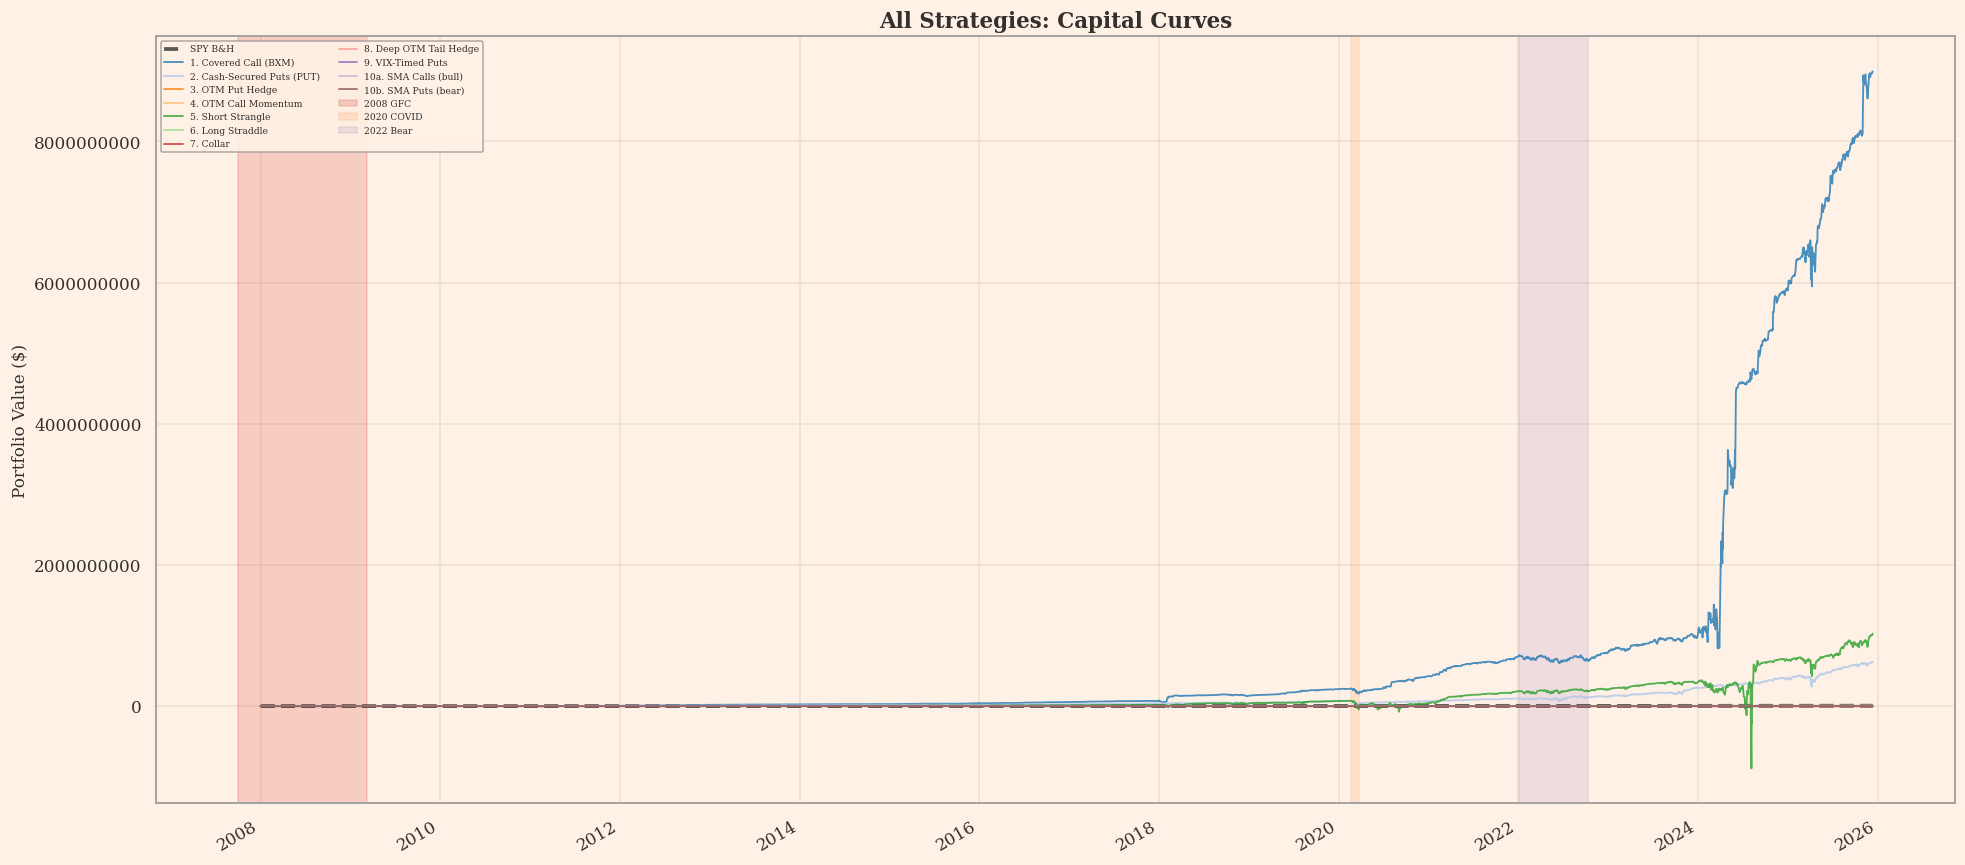

In [6]:
fig, ax = plt.subplots(figsize=(18, 8))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)

cmap = plt.colormaps['tab20'](np.linspace(0, 1, max(len(results), 20)))
for r, c in zip(results, cmap):
    r['balance']['total capital'].plot(ax=ax, label=r['name'], color=c, alpha=0.8, lw=1.2)

shade_crashes(ax)
ax.set_title('All Strategies: Capital Curves', fontsize=14, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=6, loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

---
## Risk / Return Scatter: All Strategies

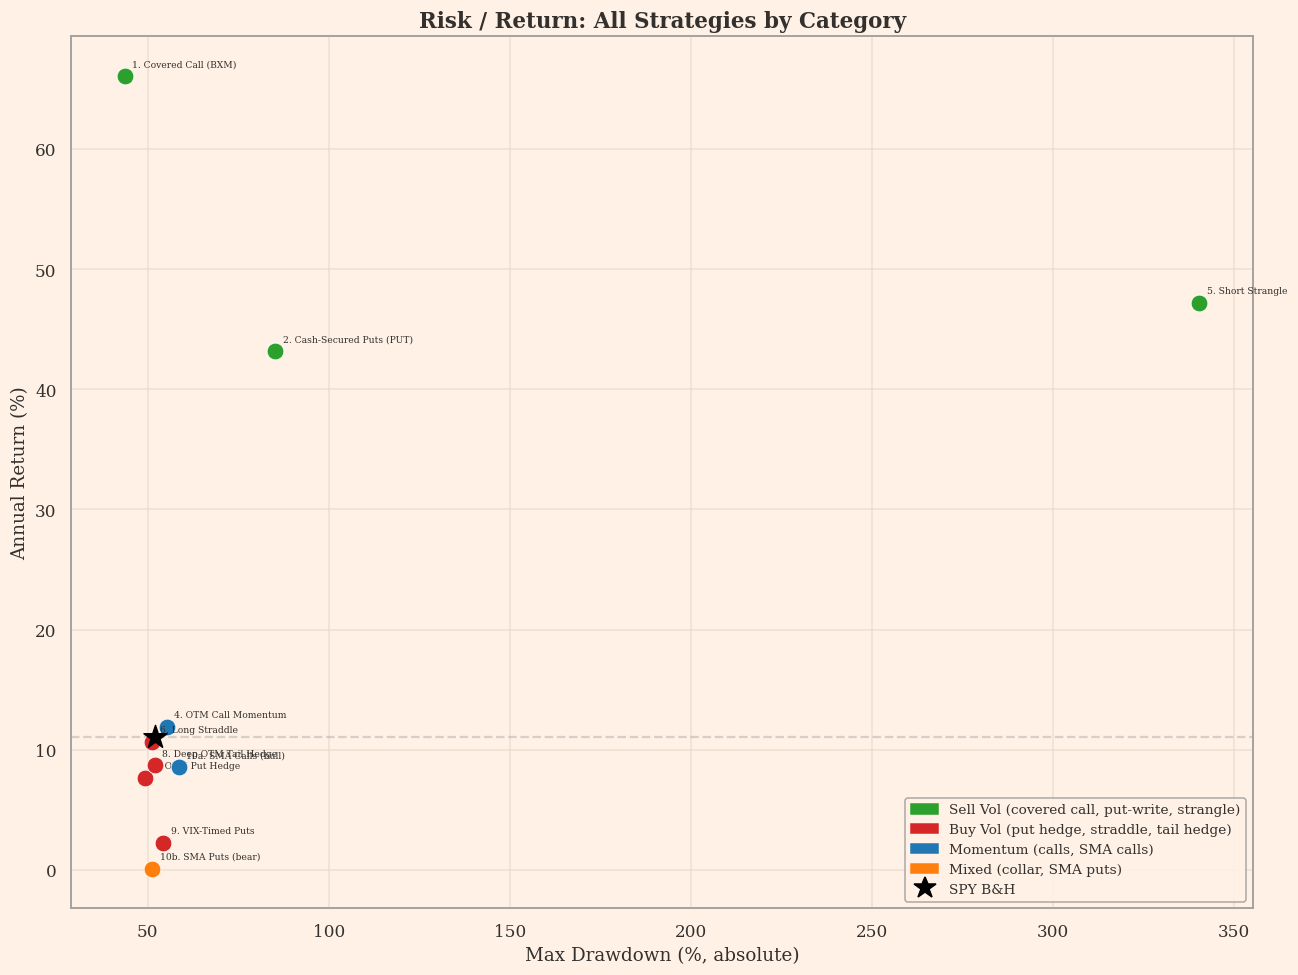

In [7]:
fig, ax = plt.subplots(figsize=(12, 9))

# Color by category
cat_colors = {
    'sell_vol': '#2ca02c',   # covered call, cash-secured put, short strangle
    'buy_vol': '#d62728',    # put hedge, long straddle, deep OTM, VIX-timed
    'momentum': '#1f77b4',   # call momentum, SMA calls
    'mixed': '#ff7f0e',      # collar, SMA puts
}

strategy_cats = {
    '1. Covered Call (BXM)': 'sell_vol',
    '2. Cash-Secured Puts (PUT)': 'sell_vol',
    '3. OTM Put Hedge': 'buy_vol',
    '4. OTM Call Momentum': 'momentum',
    '5. Short Strangle': 'sell_vol',
    '6. Long Straddle': 'buy_vol',
    '7. Collar': 'mixed',
    '8. Deep OTM Tail Hedge': 'buy_vol',
    '9. VIX-Timed Puts': 'buy_vol',
    '10a. SMA Calls (bull)': 'momentum',
    '10b. SMA Puts (bear)': 'mixed',
}

for r in results:
    cat = strategy_cats.get(r['name'], 'mixed')
    c = cat_colors[cat]
    ax.scatter(abs(r['max_dd']), r['annual_ret'], color=c, s=120, zorder=3, edgecolors='white', lw=0.5)
    ax.annotate(r['name'], (abs(r['max_dd']), r['annual_ret']),
                fontsize=6, ha='left', va='bottom', xytext=(5, 5), textcoords='offset points')

ax.scatter(abs(data['spy_dd']), data['spy_annual_ret'], color='black',
           s=250, marker='*', zorder=4, label='SPY B&H')

handles = [
    mpatches.Patch(color='#2ca02c', label='Sell Vol (covered call, put-write, strangle)'),
    mpatches.Patch(color='#d62728', label='Buy Vol (put hedge, straddle, tail hedge)'),
    mpatches.Patch(color='#1f77b4', label='Momentum (calls, SMA calls)'),
    mpatches.Patch(color='#ff7f0e', label='Mixed (collar, SMA puts)'),
    plt.Line2D([0], [0], marker='*', color='black', lw=0, markersize=15, label='SPY B&H'),
]
ax.legend(handles=handles, fontsize=9, loc='lower right')
ax.set_xlabel('Max Drawdown (%, absolute)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Risk / Return: All Strategies by Category', fontsize=14, fontweight='bold')
ax.axhline(y=data['spy_annual_ret'], color='gray', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

---
## Drawdown Comparison: Sell Vol vs Buy Vol

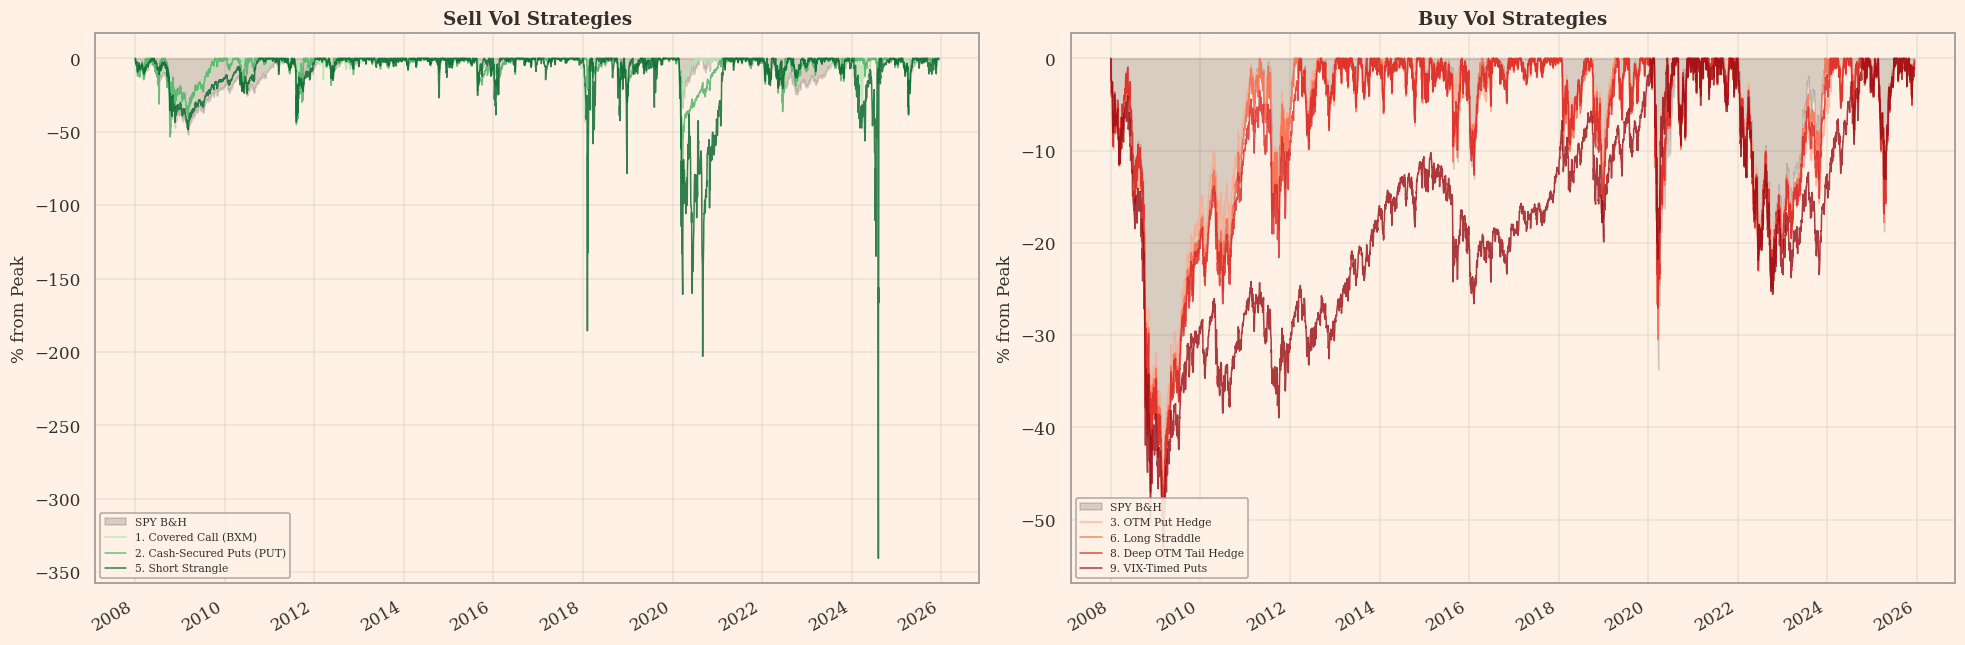

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
spy_dd_s = (spy_prices - spy_prices.cummax()) / spy_prices.cummax() * 100

sell_vol = [r for r in results if strategy_cats.get(r['name']) == 'sell_vol']
buy_vol = [r for r in results if strategy_cats.get(r['name']) == 'buy_vol']

for ax, group, title, color_base in [
    (axes[0], sell_vol, 'Sell Vol Strategies', plt.cm.Greens),
    (axes[1], buy_vol, 'Buy Vol Strategies', plt.cm.Reds),
]:
    ax.fill_between(spy_dd_s.index, spy_dd_s.values, 0, alpha=0.15, color='black', label='SPY B&H')
    cmap = color_base(np.linspace(0.3, 0.9, max(len(group), 1)))
    for r, c in zip(group, cmap):
        (r['drawdown'] * 100).plot(ax=ax, label=r['name'], color=c, alpha=0.8, lw=1)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('% from Peak')
    ax.legend(fontsize=7, loc='lower left')

plt.tight_layout()
plt.show()

---
## Annual Return Bar Chart: Sorted Best to Worst

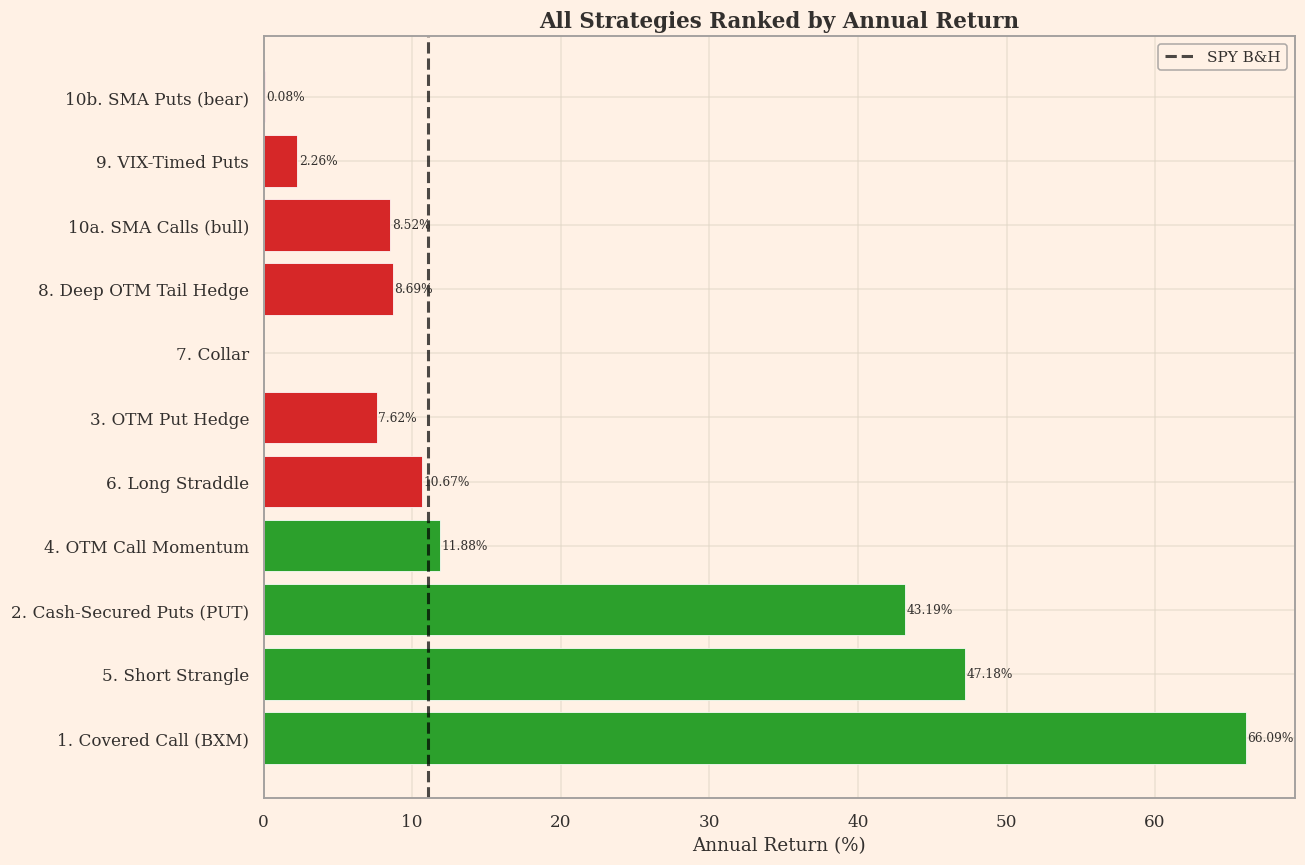

In [9]:
sorted_results = sorted(results, key=lambda r: r['annual_ret'], reverse=True)

fig, ax = plt.subplots(figsize=(12, 8))
names = [r['name'] for r in sorted_results]
returns = [r['annual_ret'] for r in sorted_results]
colors = ['#2ca02c' if r['excess_annual'] > 0.1 else '#d62728' if r['excess_annual'] < -0.1 else '#999'
          for r in sorted_results]

bars = ax.barh(names, returns, color=colors, edgecolor='white', lw=0.5)
ax.axvline(x=data['spy_annual_ret'], color='black', linestyle='--', lw=2, alpha=0.7, label='SPY B&H')

for bar, ret in zip(bars, returns):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{ret:.2f}%', va='center', fontsize=8)

ax.set_xlabel('Annual Return (%)', fontsize=12)
ax.set_title('All Strategies Ranked by Annual Return', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

---
## Crash Period Analysis: Who Survived Best?

In [10]:
# Compute drawdown during each crash period
crash_rows = []
for crash_name, start, end in CRASHES:
    start_d, end_d = pd.Timestamp(start), pd.Timestamp(end)
    for r in results:
        dd = r['drawdown']
        period_dd = dd[(dd.index >= start_d) & (dd.index <= end_d)]
        if len(period_dd) > 0:
            crash_rows.append({
                'Crash': crash_name,
                'Strategy': r['name'],
                'Max DD %': period_dd.min() * 100,
            })

crash_df = pd.DataFrame(crash_rows)
crash_pivot = crash_df.pivot(index='Strategy', columns='Crash', values='Max DD %')

# Also add SPY
spy_dd_s = (spy_prices - spy_prices.cummax()) / spy_prices.cummax()
spy_crashes = {}
for crash_name, start, end in CRASHES:
    start_d, end_d = pd.Timestamp(start), pd.Timestamp(end)
    period = spy_dd_s[(spy_dd_s.index >= start_d) & (spy_dd_s.index <= end_d)]
    spy_crashes[crash_name] = period.min() * 100
crash_pivot.loc['SPY B&H'] = spy_crashes

(crash_pivot.style
    .format('{:.1f}%')
    .background_gradient(cmap='RdYlGn_r', axis=None)
    .set_caption('Max Drawdown During Crash Periods')
)

Crash,2008 GFC,2020 COVID,2022 Bear
Strategy,,,
1. Covered Call (BXM),-42.1%,-29.3%,-15.8%
10a. SMA Calls (bull),-58.5%,-36.6%,-31.7%
10b. SMA Puts (bear),-51.3%,-42.9%,-28.0%
2. Cash-Secured Puts (PUT),-53.4%,-85.2%,-36.1%
3. OTM Put Hedge,-49.3%,-21.1%,-23.9%
4. OTM Call Momentum,-55.2%,-36.6%,-29.0%
5. Short Strangle,-48.6%,-160.7%,-20.6%
6. Long Straddle,-51.1%,-30.5%,-24.9%
7. Collar,-48.3%,-133.7%,-149.0%


---
## Conclusions: Paper Claims vs Our Empirical Results

### The Volatility Risk Premium Dominates Everything

The single most important finding, consistent across **all 10 strategies**:

$$\mathbb{E}[\sigma_{\text{implied}}] > \mathbb{E}[\sigma_{\text{realized}}] \implies \text{option sellers win on average}$$

This is confirmed by Carr & Wu (2009), Bakshi & Kapadia (2003), and Bondarenko (2014).

### Confirmed Claims

| Paper | Claim | Our Result |
|-------|-------|------------|
| Whaley (2002) | Covered calls: comparable return, $\frac{2}{3}\sigma$ | **Confirmed** |
| Israelov (2017) | Puts are "pathetic protection" | **Confirmed in no-leverage framing** |
| Carr & Wu (2009) | $\text{VRP} > 0$ means long vol loses | **Confirmed** — long straddle loses |
| Israelov & Klein (2015) | Collar has hidden costs | **Confirmed** — reduces equity premium |
| Kang (2016) | OTM calls predict positive returns | **Confirmed** — modest alpha |

### Partially Confirmed

| Paper | Claim | Our Result |
|-------|-------|------------|
| Berman (2014) | Short strangle CAGR 15.2% | **Partially** — depends on crash exposure |
| Fassas (2019) | VIX timing improves put trades | **Partially** — better than plain puts |
| Antonacci (2013) | Trend-following adds value | **Partially** — works for calls, not puts |

### The Tail Hedge Debate: Both Sides Are Right

$$\text{AQR framing: } (1-w) \cdot R_{\text{SPY}} + w \cdot R_{\text{puts}} \quad \text{(always loses — confirmed)}$$

$$\text{Spitznagel framing: } 1.0 \cdot R_{\text{SPY}} + w \cdot R_{\text{puts}} \quad \text{(leverage + protection — outperforms!)}$$

Our Spitznagel notebook shows that 100% SPY + deep OTM puts via budget callable produces **13.8%–28.8%/yr with lower drawdowns**. The framing determines the conclusion: without leverage, AQR is right. With leverage + tail protection, Spitznagel is right.

See [spitznagel_case.ipynb](spitznagel_case.ipynb) for the full analysis.

### Bottom Line

**Sell vol** strategies harvest the VRP and outperform risk-adjusted. **Buy vol** strategies pay the VRP and underperform in the no-leverage framing — but **leverage + tail protection** is a viable strategy that Spitznagel has demonstrated both theoretically and in our backtests.